# roughnecks - Engineered features
* StelllarAlgo Data Science
* Ryan Kazmerik & Nakisa Rad
* Feb 25, 2022

## Hypothesis
The goal of this notebook is to compare the results of the model with the model using standard StellarAlgo features with the engineered retention model features.

## Experiment
This section details our experiment including querying data, data transformations, feature selection and modelling.

In [1]:
import getpass
import pyodbc
import pandas as pd
import warnings
import matplotlib.pyplot as plt

from pycaret.classification import *

warnings.filterwarnings('ignore')

### Let's connect to MSSQL and run a stored proc to get our dataset:

In [2]:
# connect to SQL Server.
SERVER = '34.206.73.189'  
DATABASE = 'datascience' 
USERNAME = 'nrad' 
PASSWORD = '83F25619-D272-4660-98A2-93AF5CC18D59'#getpass.getpass(prompt='Enter your password')
CNXN = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+SERVER+';DATABASE='+DATABASE+';UID='+USERNAME+';PWD='+ PASSWORD)

In [3]:
lkupclientid = 8 # roughnecks
cursor = CNXN.cursor()

storedProc = (
    f"""Exec [stlrNLL].[ds].[getRetentionScoringModelData] {lkupclientid}"""
)

df = pd.read_sql(storedProc, CNXN)

# apply some data transformations
df["year"] = pd.to_numeric(df["year"])

CNXN.commit()
cursor.close()

df.shape

(7978, 54)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7978 entries, 0 to 7977
Data columns (total 54 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   lkupClientId            7978 non-null   int64  
 1   dimCustomerMasterId     7978 non-null   int64  
 2   customerNumber          7978 non-null   object 
 3   year                    7978 non-null   int64  
 4   productGrouping         7978 non-null   object 
 5   totalSpent              7978 non-null   float64
 6   recentDate              7978 non-null   object 
 7   attendancePercent       7978 non-null   float64
 8   renewedBeforeDays       7974 non-null   float64
 9   isBuyer                 7978 non-null   object 
 10  source_tenure           7978 non-null   int64  
 11  tenure                  7974 non-null   float64
 12  distToVenue             7978 non-null   float64
 13  totalGames              7978 non-null   int64  
 14  recency                 7978 non-null   

### We should specify the features used in our model:

In [5]:
# choose the features for the stellar base retention model
features = ["year",
            "isNextYear_Buyer",
            "productGrouping",
            "dimCustomerMasterId",
          "attendancePercent",
        "renewedBeforeDays",
        "source_tenure",
        "tenure",
        "totalGames",
        "missed_games_1",
        "missed_games_2",
        "missed_games_over_2",
        "click_link",
        "openToSendRatio",
        "clickToSendRatio",
        "clickToOpenRatio",
        "is_Lockdown",
        "NumberofGamesPerSeason"
]

# copy your main dataframe
df_dataset = df

# choose the features & train year & test year
df_dataset = df_dataset[features]
df_dataset["year"] = pd.to_numeric(df_dataset["year"])
df_dataset = df_dataset.loc[df_dataset["year"] <= 2019]

df_train = df_dataset.sample(frac=0.85, random_state=786)
df_eval = df_dataset.drop(df_train.index)

df_train.reset_index(drop=True, inplace=True)
df_eval.reset_index(drop=True, inplace=True)

# print out the number of records for training and eval
print('Data for Modeling: ' + str(df_train.shape))
print('Unseen Data For Predictions: ' + str(df_eval.shape), end="\n\n")

Data for Modeling: (5700, 18)
Unseen Data For Predictions: (1006, 18)



### Now we can model the data using a binary classification prediction for the isnextyear_buyer field to see how likely a customer is to re-purchase.

In [6]:
setup(
    data= df_train, 
    target="isNextYear_Buyer", 
    train_size = 0.85,
    data_split_shuffle=True,
    ignore_features=["dimCustomerMasterId","productGrouping","year"],
    silent=True,
    verbose=False,
    numeric_features=[
        "attendancePercent",
        "renewedBeforeDays",
        "source_tenure",
        "tenure",
        "totalGames",
        "missed_games_1",
        "missed_games_2",
        "missed_games_over_2",
        "click_link",
        "openToSendRatio",
        "clickToSendRatio",
        "clickToOpenRatio",
        "is_Lockdown",
        "NumberofGamesPerSeason"
    ]
);

In [7]:
model_matrix = compare_models(
    fold=10,
    include=["lr", "xgboost"]
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.8481,0.8516,0.9450,0.8419,0.8904,0.6455,0.6573,0.5100
xgboost,Extreme Gradient Boosting,0.8429,0.8545,0.9345,0.8423,0.8859,0.6357,0.6450,0.4720


In [8]:
best_model = create_model(model_matrix)
final_model = finalize_model(best_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8557,0.8578,0.9338,0.8580,0.8943,0.6683,0.6742
1,0.8515,0.8342,0.9527,0.8412,0.8935,0.6517,0.6656
2,0.8598,0.8546,0.9525,0.8503,0.8985,0.6742,0.6856
3,0.8206,0.8222,0.9399,0.8137,0.8722,0.5764,0.5935
4,0.8471,0.8347,0.9557,0.8343,0.8909,0.6396,0.6562
5,0.8326,0.8510,0.9367,0.8291,0.8796,0.6084,0.6207
6,0.8574,0.8548,0.9525,0.8479,0.8972,0.6674,0.6795
7,0.8471,0.8543,0.9430,0.8418,0.8896,0.6438,0.6549
8,0.8574,0.8792,0.9462,0.8519,0.8966,0.6693,0.6790
9,0.8512,0.8738,0.9367,0.8506,0.8916,0.6565,0.6643


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-le

### Let's load in our 2021 season data and get retention scores using the model:

In [9]:
df_inference = df.loc[df["year"] >= 2021]
df_inference = df_inference.fillna(0)
df_inference.shape

(1272, 54)

In [10]:
new_predictions = predict_model(final_model, data=df_inference, raw_score=True)
new_predictions.head()

,lkupClientId,dimCustomerMasterId,customerNumber,year,productGrouping,totalSpent,recentDate,attendancePercent,renewedBeforeDays,isBuyer,...,education,urbanicity,credits_after_refund,is_Lockdown,NumberofGamesPerSeason,CNTPostponedGames,isNextYear_Buyer,Label,Score_0,Score_1
6706,8,328763142,11004756,2021,Full Season,693.69,2022-02-18,1.500000,98.0,TRUE,...,0,0,0.0,1,10,0,0,0,0.9922,0.0078
6707,8,328764274,10637758,2021,Full Season,768.48,2022-02-18,2.000000,154.0,TRUE,...,0,0,0.0,1,10,0,0,0,0.9980,0.0020
6708,8,328772302,4169344,2021,Full Season,2012.20,2022-02-18,1.166667,51.0,TRUE,...,0,0,0.0,1,10,0,0,0,0.9668,0.0332
6709,8,328780616,3720532,2021,Full Season,1223.36,2022-02-11,1.000000,154.0,TRUE,...,0,0,0.0,1,10,0,0,0,0.9949,0.0051
6710,8,328784787,7594832,2021,Full Season,1516.75,2022-02-18,1.000000,98.0,TRUE,...,0,0,0.0,1,10,0,0,0,0.9679,0.0321


In [11]:
new_predictions["Label"].value_counts()

0    1270
1       2
Name: Label, dtype: int64

In [12]:
new_predictions["Score_1"].value_counts(bins=[0, 0.2, 0.4, 0.6, 0.8, 1.0])

(-0.001, 0.2]    1263
(0.2, 0.4]          7
(0.8, 1.0]          2
(0.4, 0.6]          0
(0.6, 0.8]          0
Name: Score_1, dtype: int64

array([[<AxesSubplot:title={'center':'Score_1'}>]], dtype=object)

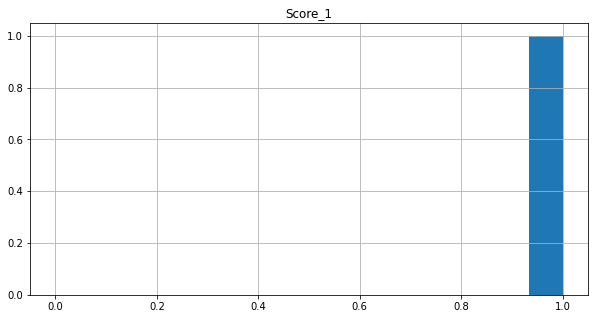

In [13]:
new_predictions[new_predictions["Label"]==1][["Score_1"]].hist(bins=30, figsize=(10,5), range=[0,1])

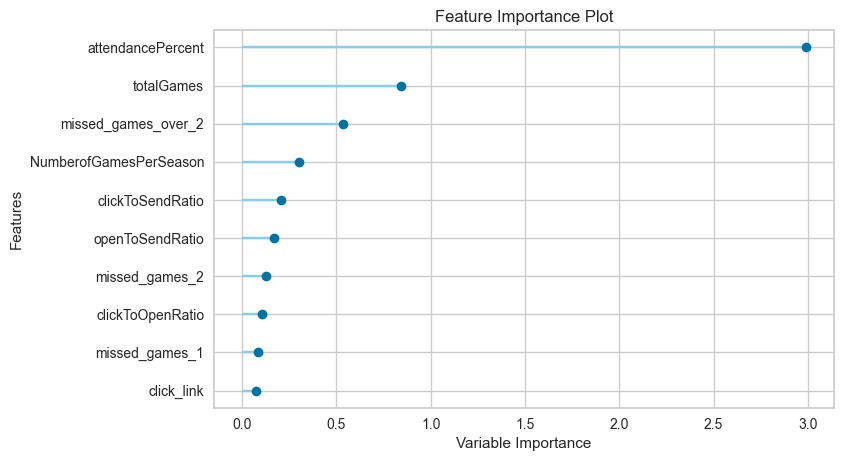

In [14]:
plot_model(best_model, plot='feature')

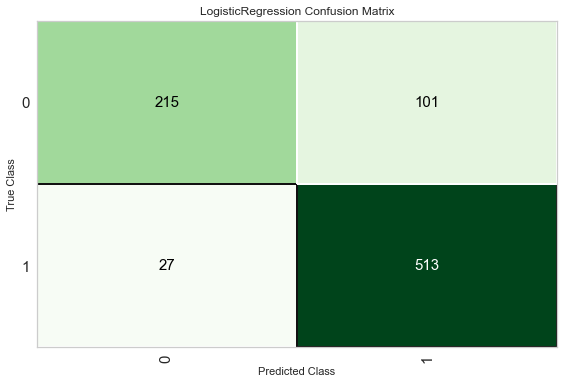

In [15]:
plot_model(best_model, plot='confusion_matrix')

## Observations
Here you can document some ideas on the results from above


## Conclusions
Here you can talk about next steps, did the experiment work? If yes, what to do next? If no, why?